In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

from dataset import VQAv2Eval
from inference_pipeline import InferencePipeline
import time
from scoring_pipeline import ScoringPipeline

from dataset import VQAv2Eval
import os
from awq.llava_quantizer import LlavaAWQQuantizer


/fs/nexus-scratch/vla/micromamba/envs/MMQ_LLAVA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
device

device(type='cuda')

In [4]:
# VQAv2 dataset paths
ann_root = '/fs/cfar-projects/low-bit-vision/datasets/vqav2/annotations'
q_root = '/fs/cfar-projects/low-bit-vision/datasets/vqav2/questions'
image_root = '/fs/cfar-projects/low-bit-vision/datasets/vqav2/val2014'


dataset = VQAv2Eval(image_root=image_root,
                    ann_root=ann_root,
                    q_root=q_root,)

In [5]:
# Load the model
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16, device_map="auto")
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", pad_token = '<pad>')

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
# FP output
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://www.ilankelman.org/stopsigns/australia.jpg"},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, torch.float16)

with torch.no_grad():
    # Generate
    generate_ids = model.generate(**inputs, max_new_tokens=30)
    
    print(processor.batch_decode(generate_ids, skip_special_tokens=True))

['USER:  \nWhat is shown in this image? ASSISTANT: The image shows a street scene with a stop sign, a car driving down the street, and a red and white building in the background. There are']


In [7]:
config = {}

config['vision_layers'] = {
    'self_attn':2,
    'mlp': 2
}

# config['llm_layers'] = {
#     'self_attn': 4,
#     'mlp': 4
# }

config

{'vision_layers': {'self_attn': 2, 'mlp': 2}}

In [8]:
quantizer = LlavaAWQQuantizer(model, device, processor, dataset, config)

In [9]:
quantizer.quantize()

layer_groups: {'vision_layers': ModuleList(
  (0-23): 24 x CLIPEncoderLayer(
    (self_attn): CLIPSdpaAttention(
      (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (mlp): CLIPMLP(
      (activation_fn): QuickGELUActivation()
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    )
    (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
)}


Quantizing vision_layers: 100%|██████████| 24/24 [03:22<00:00,  8.42s/it]


In [10]:
model = model.to('cuda')

# quantized output
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://www.ilankelman.org/stopsigns/australia.jpg"},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, torch.float16)

with torch.no_grad():
    # Generate
    generate_ids = model.generate(**inputs, max_new_tokens=30)
    
    print(processor.batch_decode(generate_ids, skip_special_tokens=True))

['USER:  \nWhat is shown in this image? ASSISTANT: The image shows a close-up view of a wall, possibly with a brick.']


In [11]:
# grouped_mods, first_inputs, layer_args, layer_kwargs, linear_inputs = quantizer.quantize()

In [12]:
dataset[42]

{'image': <PIL.Image.Image image mode=RGB size=640x480>,
 'text_input': 'Question: Are there any boxes in the room? Short answer:',
 'question_id': 262162024}

In [13]:
dataset.qa_pairs[42]

{'question_id': 262162024,
 'question': 'Are there any boxes in the room?',
 'answer': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'],
 'image': 'COCO_val2014_000000262162.jpg'}

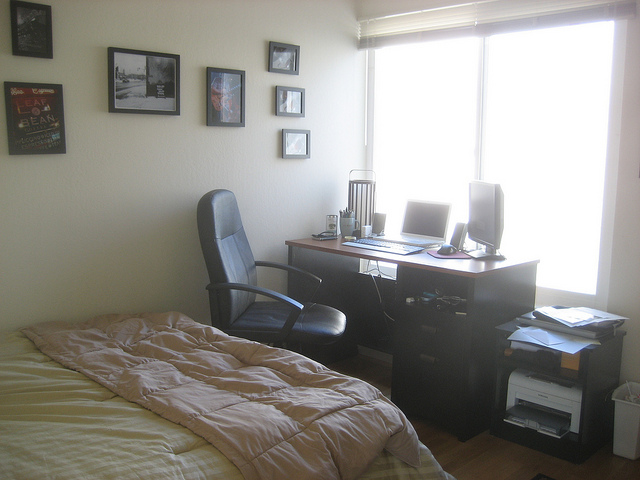

In [14]:
dataset[42]['image']

In [15]:
img = dataset[1]['image']
prompt = 'USER: <image>\n' + dataset.qa_pairs[42]['question'] + '\nAnswer the question using a single word or phrase. ASSISTANT:'

print(prompt)

USER: <image>
Are there any boxes in the room?
Answer the question using a single word or phrase. ASSISTANT:


In [16]:
model = model.to('cuda')
samples = processor(images = [img],
                     text=[prompt],
                     return_tensors='pt',
                     padding=True).to(model.device)

samples.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [17]:
# Generate
# generate_ids = model.generate(**inputs, max_new_tokens=30)
generate_ids = model.generate(**samples)
processor.batch_decode(generate_ids, skip_special_tokens=True)

['USER:  \nAre there any boxes in the room?\nAnswer the question using a single word or phrase. ASSISTANT: No']